# Manifesto Analysis
Here we analyze the parties' manifestos.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Variables
### Parties and elections

In [2]:
parties = {'union': 'Union',
         'spd': 'SPD',
         'afd': 'AfD',
         'fdp': 'FDP',
         'linke': 'Die Linke',
         'grüne': 'Die Grünen'}
elections = ['bt', 'eu']

### Colors

In [3]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Methods

### Cleaning and tokenization

0. (Optional, default off) Replace numbers with nothing
1. Replaces `<URL>` with single space
1. Replaces `_` with space
1. Replaces `<Non-Ascii except ÄäÜüÖöß>` with nothing
2. Replaces `<letter>-<letter>` with `<letter><letter>`
2. Replaces `<letter>*<letter>` with `<letter><letter>`
3. Replaces `<non-words>-<newline><non-words>` with nothing
4. Replaces `<non-words><newline><non-words>` with single space
5. Replaces `<non-words>` with single space

In [4]:
import re

def clean_and_tokenize(text, remove_numbers=False, min_len=None):
    if remove_numbers:
        replaced = re.sub(r'\d+', ' ', text)
    else:
        replaced = text
        
    replaced = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', replaced)
    replaced = replaced.replace('_', ' ')
    replaced = ''.join([i if ord(i) < 128 or ord(i) in [228,196,246,214,252,220,223] else '' for i in replaced])
    replaced = re.sub(r'(\w)-(\w)', r'\1\2', replaced)
    replaced = re.sub(r'(\w)\*(\w)', r'\1\2', replaced)
    replaced = re.sub(r'\W*-\\n\W*', '', replaced)
    replaced = re.sub(r'\W*\\n\W*', ' ', replaced)
    replaced = re.sub(r'\W+', ' ', replaced)
    if min_len:
        return [word for word in replaced.split() if len(word) >= min_len]
    else:
        return replaced.split()

### Stop words


In [5]:
from nltk.corpus import stopwords

stop = set(stopwords.words('german'))

def filter_stop_words(word_list):
    def is_stop_word(word):
            return (word.lower() in stop) or (word.capitalize() in stop)
    return [word for word in word_list if not is_stop_word(word)]

### Dictionary
Not used

In [6]:
from enchant import Dict

dic = Dict("de_DE")

def test_dictionary(word):
    return dic.check(word.lower()) or dic.check(word.capitalize())

### Lemmatization
#### Spacy lemmatizer

In [7]:
from spacy.lang.de import lemmatizer

def lemmatize_spacy(word):
    try:
        return lemmatizer.LOOKUP[word]
    except: pass
    
    # Try to lemmatize lower word version
    try:
        return lemmatizer.LOOKUP[word.lower()]
    except: pass
    
    # Try to lemmatize capitalized word version
    try:
        return lemmatizer.LOOKUP[word.capitalize()]
    except: pass

#### Treetagger lemmatizer

In [8]:
from treetaggerwrapper import TreeTagger

tagger = TreeTagger(TAGLANG='de')

def lemmatize_tt(word):
    
    def lemmatize(w):
        tt_lower = tagger.tag_text([w], tagonly=True)[0].split('\t')[-1]
        if tt_lower != w:
            return tt_lower.split("|")[-1]
        
    if not word.isalpha():
        return None
    
    lem = lemmatize(word)
    if lem is not None:
        return lem
    
    # Try to lemmatize lower word version
    lem = lemmatize(word.lower())
    if lem is not None:
        return lem
    
    # Try to lemmatize capitalized word version
    lem = lemmatize(word.capitalize())
    if lem is not None:
        return lem

/usr/lib/python3.7/site-packages/treetaggerwrapper.py:740: FutureWarning: Possible nested set at position 8
  re.IGNORECASE | re.VERBOSE)
/usr/lib/python3.7/site-packages/treetaggerwrapper.py:2044: FutureWarning: Possible nested set at position 152
  re.VERBOSE | re.IGNORECASE)
/usr/lib/python3.7/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/usr/lib/python3.7/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


#### Lemmatizer combiner
- If one lemmatizer exclusively modifies the word, it returns this lemmatized version
- If both lemmatizer modify the word, it returns the spaCy version
- If neither one modifies the word, it returns just the word

In [9]:
def lemmatize_combined(word):
    sp = lemmatize_spacy(word)
    tt = lemmatize_tt(word)
    if sp is not None:
        return sp
    elif tt is not None:
        return tt
    else:
        return word
    
    
def lemmatize_list(word_list):
    return [lemmatize_combined(word) for word in word_list]

### Visualization

In [77]:
from matplotlib.ticker import MaxNLocator
from itertools import chain
from IPython.display import display_html
import matplotlib.patches as mpatches

def plot_bar(data, label):
    """ Returns a bar chart in which a DataFrame is visualized.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax.set_ylabel(label);
    color_map = [colors[party] for party in parties]
    ax.bar(parties, channel_count[parties], color=color_map, width=.8)
    return fig


def plot_compare_bar(bt_data, eu_data, label, left=False):
    """ Returns a bar chart where two DataFrames are compared.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    color_map_dark = [colors[party] for party in parties]
    color_map_light = [colors_light[party] for party in parties]
    ax.bar(parties.values(), bt_data[parties.keys()], color=color_map_dark, width=-.4, align='edge')
    ax.bar(parties.values(), eu_data[parties.keys()], color=color_map_light, width=.4, align='edge')
    print_legend(ax, left)
    return fig

def generate_wordcloud(weight_dic, title):
    """ The following function takes a weight matrix as an input with parties as columns and words as indices.
    """
    fig, axs = plt.subplots(2, 3, figsize=(18, 7))
    #plt.suptitle(title, size=25, weight='bold')
    axis = chain.from_iterable(zip(*axs))
    for party, ax in zip(weight_dic, axis):
        # Visuals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title(party.upper(), size=20)
        color_func = lambda *args, **kwargs: colors[party]
        # Weights and Clourd
        word_weights = weight_dic[party]
        word_cloud = WordCloud(background_color='white', height=500, width=1000, color_func=color_func)
        image = word_cloud.generate_from_frequencies(word_weights)
        ax.imshow(image, interpolation='bilinear')
    return fig
        
def display_side_by_side(dfs):
    """ Displays mutiple panda DataFrames side by side.
    """
    html_str=''
    for df in dfs:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)    
    
def top_n(df, column, n):
    """ Sorts a pandas DataFrame and returns the first n entries of a specific column.
    """
    return df[[column]].sort_values(ascending=False, by=column).iloc[:n]


def print_legend(ax, left=False):
    """ Prints a fancy legend for the comparing bar plot
    """
    if left:
        label = ax.annotate('Bundestag election\n European election', xy=(0, 1), xytext=(57, -10),
                        fontsize=13, horizontalalignment='left', verticalalignment='top',
                        xycoords='axes fraction', textcoords='offset points',)
    else:
        label = ax.annotate('Bundestag election\n European election', xy=(1, 1), xytext=(-15, -10),
                        fontsize=13, horizontalalignment='right', verticalalignment='top', 
                        xycoords='axes fraction', textcoords='offset points')
    ax.figure.canvas.draw()
    bbox = label.get_window_extent()
    bbox_data = ax.transData.inverted().transform(bbox) 
    text_x_left = bbox_data[0][0]
    text_x_right = bbox_data[1][0]
    text_y_bottom = bbox_data[0][1]
    text_y_top = bbox_data[1][1]

    text_width = text_x_right - text_x_left
    text_height = text_y_top - text_y_bottom

    patches_width = 0.4 * text_width
    x_box_border = 0.04 * text_width
    y_box_border = 0.04 * text_height

    box_width = patches_width + text_width + 2 * x_box_border
    box_height = text_height + 5 * y_box_border

    box_position = (text_x_left-patches_width-x_box_border, text_y_bottom - 2 * y_box_border)

    box = mpatches.Rectangle(box_position, box_width, box_height, alpha=.2, facecolor='white', edgecolor='black')
    ax.add_patch(box)

    num_patches = len(parties)
    patch_width = (patches_width - 2 * x_box_border)/num_patches
    patch_height = (box_height/2 - 4.5 * y_box_border)

    for num, party in enumerate(parties):
        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, color=colors_light[party])
        ax.add_patch(patch)

        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + box_height - patch_height - 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, color=colors[party])
        ax.add_patch(patch)

### Corpus

Loads political manifestos and extracts text using [pdftotext](https://github.com/jalan/pdftotext).

In [11]:
import pdftotext

def get_pdf_text(party, election):
    with open("../rsc/wahlprogramme/{0}_{1}.pdf".format(party, election), "rb") as f:
        pdf = pdftotext.PDF(f)
        return " ".join(pdf)
    
    
def get_text_df():
    rows = [(party, election, get_pdf_text(party, election)) 
            for party in parties 
            for election in elections]
    return pd.DataFrame(rows, columns=['party','election','text'])
            
    
def preprocess_text(text):
    return text.apply(clean_and_tokenize) \
                .apply(filter_stop_words) \
                .apply(lemmatize_list) \
                .apply(lambda l: [word.lower() for word in l]) \


def merge(texts):
    return [word for word_list in texts for word in word_list]

## Plotting
### Get corpus

In [12]:
action = 'load'

if action == 'generate':
    unprocessed_corpus = get_text_df()
    corpus = unprocessed_corpus.copy()
    corpus['text'] = preprocess_text(corpus['text'])
elif action == 'load':
    unprocessed_corpus = pd.read_pickle("./store/manifesto_unprocessed_corpus.pkl")
    corpus = pd.read_pickle("./store/manifesto_corpus.pkl")
elif action == 'save':
    unprocessed_corpus.to_pickle("./store/manifesto_unprocessed_corpus.pkl")
    corpus.to_pickle("./store/manifesto_corpus.pkl")

In [13]:
unprocessed_corpus

,party,election,text
0,union,bt,"Für ein Deutschland,\nin dem wir gut\nund gern..."
1,union,eu,"Unser Europa macht stark.\nFür Sicherheit,\nFr..."
2,spd,bt,Zeit für\nmehr\nGerechtigkeit.\nUnser Regierun...
3,spd,eu,KOMMT ZUSAMMEN\nUND MACHT EUROPA STARK!\n...
4,afd,bt,PROGRAMM FÜR\nDEUTSCHLAND\nWahlprogramm der Al...
5,afd,eu,EUROPAWAHLPROGRAMM\n Programm der Alterna...
6,fdp,bt,DENKEN\nWIR NEU.\n DAS PROGRAMM\n DE...
7,fdp,eu,Europas\n Chancen\n nutzen.\nDas Programm der...
8,linke,bt,"Die Zukunft,\n für die wir\n ..."
9,linke,eu,Europawahl 2019\nWahlprogramm\nwww.europa-nur-...


In [14]:
corpus

,party,election,text
0,union,bt,"[deutschland, gut, gerne, leben, regierungspro..."
1,union,eu,"[europa, machen, stark, sicherheit, friede, wo..."
2,spd,bt,"[zeit, mehr, gerechtigkeit, regierungsprogramm..."
3,spd,eu,"[kommen, zusammen, machen, europa, stark, wahl..."
4,afd,bt,"[programm, deutschland, wahlprogramm, alternat..."
5,afd,eu,"[europawahlprogramm, programm, alternativ, deu..."
6,fdp,bt,"[denken, neu, programm, frei, demokrat, bundes..."
7,fdp,eu,"[europa, chance, nutzen, programm, freie, demo..."
8,linke,bt,"[zukunft, kampf, langfassung, wahlprogramm, bu..."
9,linke,eu,"[europawahl, 2019, wahlprogramm, www, europanu..."


In [15]:
long_words = [word for word in chain.from_iterable(corpus['text']) if len(word) > 35]
print(long_words)
long_word_indices = corpus['text'].apply(lambda l: any(w in l for w in long_words))
corpus[long_word_indices]

['körperschaftsteuerbemessungsgrundlage', 'fingerabdruckidentifizierungssystems', 'allgemeinverbindlichkeitserklärungen', 'körperschaftsteuerbemessungsgrundlage']


,party,election,text
1,union,eu,"[europa, machen, stark, sicherheit, friede, wo..."
2,spd,bt,"[zeit, mehr, gerechtigkeit, regierungsprogramm..."
10,grüne,bt,"[zukunft, mut, machen, bundestagswahlprogramm,..."


### Manifesto size

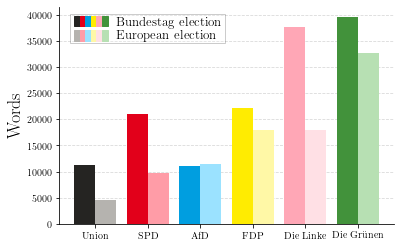

In [16]:
bt_size = corpus[corpus.election == 'bt'].groupby('party')['text'].sum().apply(lambda x: len(x))
eu_size = corpus[corpus.election == 'eu'].groupby('party')['text'].sum().apply(lambda x: len(x))
fig = plot_compare_bar(bt_size, eu_size, "Words", left=True)
fig.savefig('outputs/manifesto-word-count.pdf', bbox_inches = 'tight', pad_inches = 0)

In [17]:
print("Total number of words contained in all manifestos:", corpus['text'].apply(lambda x: len(x)).sum())

Total number of words contained in all manifestos: 236967


### Topic analysis
#### tf-idf

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer


def distinct(df, n=10):
    """ Takes a pandas matrix, where rows are words and columns parties, 
    and returns the n highest distinct words.
    """
    matrix = df.copy()
    parties = matrix.columns
    entries = {party: [] for party in parties}
    while any(map(lambda key: len(entries[key]) < n, entries)):
        next_party = matrix.max().idxmax()
        word = matrix[next_party].idxmax()
        matrix.drop(word, inplace=True)
        entries[next_party].append(word)
        if len(entries[next_party]) >= n:
            matrix.drop(next_party, axis=1, inplace=True)
    return pd.DataFrame(entries)

def print_distinct_tfidf_table(corp, n=10):
    tfidf = TfidfVectorizer(sublinear_tf=True, 
                             preprocessor=lambda x: x, 
                             tokenizer=lambda x: x,
                             strip_accents='unicode')

    corpora = (corp[party] for party in parties)
    x = tfidf.fit_transform(corpora)
    df = pd.DataFrame(x.T.toarray(), index=tfidf.get_feature_names(), columns=parties)
    dis = distinct(df, n)
    display_side_by_side(dis[[party]] for party in parties)
    return {party: {word: df.loc[word, party] for word in dis[party]} for party in parties}

In [85]:
bt = corpus[corpus.election == 'bt'].groupby('party')['text'].sum().apply(lambda l: [w for w in l if len(w) > 5 and w.isalpha()])
eu = corpus[corpus.election == 'eu'].groupby('party')['text'].sum().apply(lambda l: [w for w in l if len(w) > 5 and w.isalpha()])
tfidf_bt = print_distinct_tfidf_table(bt, 20)
tfidf_eu = print_distinct_tfidf_table(eu, 20)


,union
0,wahlperiode
1,deutschland
2,marshallplan
3,verlässlichkeit
4,ballungsraum
5,mensch
6,deshalb
7,digitalisierung
8,wichtig
9,stärken


,union
0,europa
1,europäisch
2,champions
3,stabilitätsunion
4,westen
5,zukunftsprojekt
6,gemeinsam
7,computer
8,gesellschaftsordnung
9,hervor


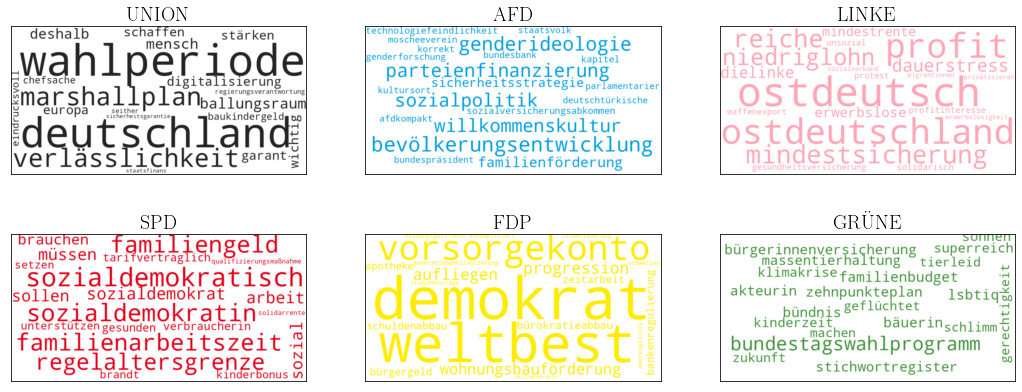

In [86]:
from wordcloud import WordCloud

fig = generate_wordcloud(tfidf_bt, "TF-IDF - 2016 Bundestag election - Manifesto corpus")
fig.savefig('outputs/manifesto-tfidf-wordcloud-bt.pdf', bbox_inches = 'tight', pad_inches = 0)

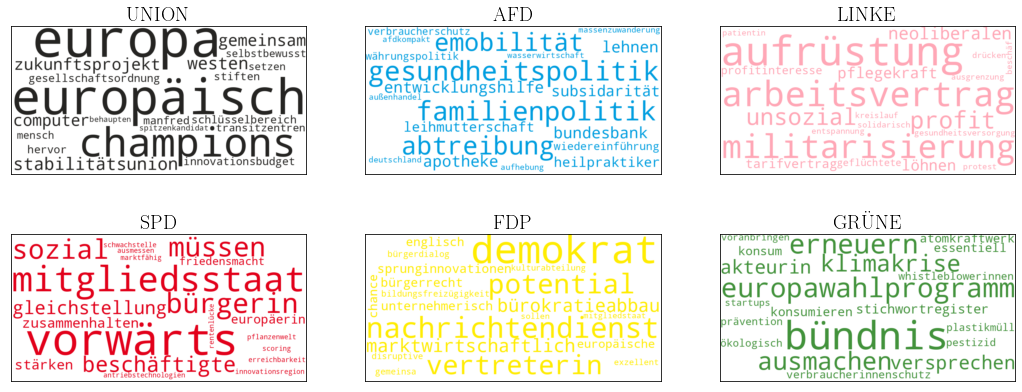

In [87]:
fig = generate_wordcloud(tfidf_eu, "TF-IDF - 2019 European election - Manifesto corpus")
fig.savefig('outputs/manifesto-tfidf-wordcloud-eu.pdf', bbox_inches = 'tight', pad_inches = 0)


## LDA

### Dataset preparation

In [127]:
bt_splitted = pd.DataFrame(([party, bt[party][i:i+283]] for party in parties for i in np.arange(0, len(bt[party]), 282)), columns=['party', 'tokens'])
eu_splitted = pd.DataFrame(([party, eu[party][i:i+283]] for party in parties for i in np.arange(0, len(eu[party]), 282)), columns=['party', 'tokens'])

In [128]:
bt_splitted[:10]

,party,tokens
0,union,"[deutschland, regierungsprogramm, inhaltsverze..."
1,union,"[bundeskanzlerin, angela, merkel, rentenreform..."
2,union,"[unternehmer, setzen, aufstiegschance, bereite..."
3,union,"[angeboten, ausbildungsplatz, übersteigen, zah..."
4,union,"[schaffen, lebensqualität, finden, zahlen, lan..."
5,union,"[bedingung, wagniskapital, verbessern, startup..."
6,union,"[anpassen, produktionsgrundlage, landwirt, flä..."
7,union,"[bremseinrichtung, ausrüsten, auffahrunfall, v..."
8,union,"[stromerzeugung, konsequent, deutschland, einh..."
9,union,"[erziehung, übernehmen, leiste, wertvoll, beit..."


#### Determine number of topics

In [228]:
import gensim
from gensim.models import CoherenceModel

mallet_path = '/home/rattletat/mallet/bin/mallet' 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, update_every=1, chunksize =10000, passes=5) 
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print("Status: ", num_topics)

    return model_list, coherence_values

In [229]:
bt_dictionary = gensim.corpora.Dictionary(bt_splitted['tokens'])
eu_dictionary = gensim.corpora.Dictionary(bt_splitted['tokens'])
bt_corp = [dictionary.doc2bow(text) for text in bt_splitted['tokens']]
eu_corp = [dictionary.doc2bow(text) for text in eu_splitted['tokens']]
# Can take a long time to run.
bt_model_list, bt_coherence_values = compute_coherence_values(dictionary=bt_dictionary, corpus=bt_corp, texts=bt_splitted['tokens'], start=10, limit=500, step=10)
eu_model_list, eu_coherence_values = compute_coherence_values(dictionary=eu_dictionary, corpus=eu_corp, texts=eu_splitted['tokens'], start=10, limit=500, step=10)

Status:  10
Status:  20
Status:  30
Status:  40
Status:  50
Status:  60
Status:  70
Status:  80
Status:  90


/usr/lib/python3.7/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Status:  100
Status:  110
Status:  120
Status:  130
Status:  140
Status:  150
Status:  160
Status:  170
Status:  180
Status:  190
Status:  200
Status:  210
Status:  220
Status:  230
Status:  240
Status:  250
Status:  260
Status:  270
Status:  280
Status:  290
Status:  300
Status:  310
Status:  320
Status:  330
Status:  340
Status:  350
Status:  360
Status:  370
Status:  380
Status:  390


KeyboardInterrupt: 

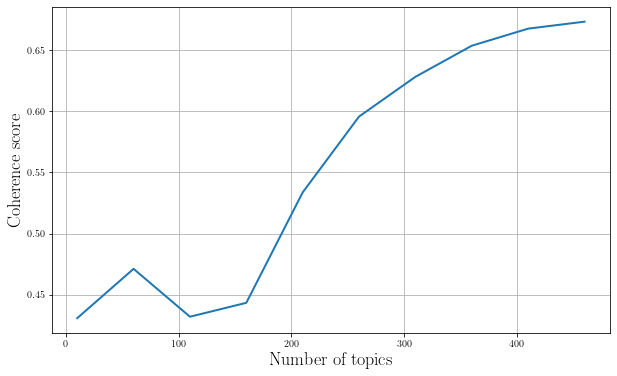

In [240]:
from matplotlib.pyplot import figure

# Show graph
start=10; limit=500; step=50;
x = range(start, limit, step)
figure(num=None, figsize=(10, 6))
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.grid()
#plt.legend("coherence_values", loc='best')
plt.savefig('outputs/number_of_topics-manifesto.pdf', bbox_inches = 'tight', pad_inches = 0)

In [166]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4307
Num Topics = 60  has Coherence Value of 0.4711
Num Topics = 110  has Coherence Value of 0.4319
Num Topics = 160  has Coherence Value of 0.4433
Num Topics = 210  has Coherence Value of 0.5337
Num Topics = 260  has Coherence Value of 0.5958
Num Topics = 310  has Coherence Value of 0.6283
Num Topics = 360  has Coherence Value of 0.6538
Num Topics = 410  has Coherence Value of 0.6678
Num Topics = 460  has Coherence Value of 0.6735


In [167]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(128,
  '0.043*"umfassend" + 0.035*"spielen" + 0.021*"notwendigkeit" + 0.021*"gesundheits" + 0.021*"kinderbetreuung" + 0.014*"legislativ" + 0.014*"gleichberechtigt" + 0.014*"alterssicherungspolitik" + 0.014*"friedensdiplomatie" + 0.014*"lobbyistin"'),
 (4,
  '0.056*"bereich" + 0.053*"umsetzung" + 0.053*"einfahren" + 0.035*"förderung" + 0.032*"strukturell" + 0.032*"aktionsplan" + 0.032*"einrichten" + 0.028*"dienst" + 0.028*"gleichberechtigt" + 0.025*"verpflichtend"'),
 (12,
  '0.086*"dürfen" + 0.062*"gesetz" + 0.062*"stehen" + 0.052*"treten" + 0.048*"privat" + 0.045*"transparent" + 0.036*"bestimmen" + 0.028*"beratung" + 0.026*"umfassen" + 0.024*"regelung"'),
 (74,
  '0.083*"mittelfristig" + 0.042*"längst" + 0.035*"betreiber" + 0.028*"beruhen" + 0.021*"mindeststandard" + 0.014*"verfügbar" + 0.014*"konzentration" + 0.014*"vorhalten" + 0.014*"gewährleisten" + 0.014*"wehren"'),
 (136,
  '0.077*"initiative" + 0.019*"vertragsnaturschutz" + 0.019*"freundlich" + 0.019*"meinsam" + 0.010*"geführ

#### Calculate LDA model

In [239]:
#model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corp, num_topics=250, id2word=dictionary)
model = gensim.models.ldamodel.LdaModel(corpus=corp, id2word=dictionary, num_topics=380, update_every=1, chunksize =10000, passes=10)

/usr/lib/python3.7/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


#### Print models

In [241]:
def print_topics_gen(lda_model, count_vectorizer, num_words=20):
    for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words, num_topics=10):
        print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

In [242]:
print_topics_gen(model, dictionary)

Topic: 138 
Words: steuer|national|unternehmen|international|steuerhinterziehung|europäisch|steuerbetrug|geldwäsche|steuern|transparenz|gewinnen|bekämpfen|verhindern|sollen|europa|kommune|hausen|tatsächlich|steuervermeidung|bemessungsgrundlage
Topic: 188 
Words: international|zusammenarbeit|deutschland|europa|militärisch|europäisch|global|blicken|gerechtigkeit|solidarisch|stärken|bundestagswahlprogramm|europäer|europäerin|wirtschaftsleistung|endlich|erheblich|nationalistisch|geflüchtet|fluchtursache
Topic: 90 
Words: fluchtweg|lösung|rungsgesellschaft|geltend|restriktiv|massenunter|derten|unterbringen|sofortprogramm|reaktionär|entrechtung|verweildauern|künften|aktuell|aufgabe|status|sportver|zivilgesellschaftlich|infrastruktur|antwort
Topic: 269 
Words: mensch|türkei|demokrat|gesellschaft|sozial|chance|setzen|bundestagswahlprogramm|deutschland|bleiben|fordern|müssen|grundlage|sollen|wichtig|nutzen|zukunft|gerechtigkeit|sicherheitspolitisch|schaffen
Topic: 202 
Words: zielen|deutschland

#### Create topic classes

In [249]:
environmental_words = ['klima', 'tierhaltung', 'ökologisch', 'nachhaltig', 'erneuerbar']
refugee_words = ['flüchtling', 'asyl', 'einwanderung', 'migrant', 'zuwanderung']

environmetal_topics = set()
refugee_topics = set()

for idx, topic in model.show_topics(formatted=False, num_words=10, num_topics=-1):
    for w in topic:
        if any(w[0] in env or env in w[0] for env in environmental_words):
            environmetal_topics.add(idx)
        if any(w[0] in ref or ref in w[0] for ref in refugee_words):
            refugee_topics.add(idx)        
            
distinct_environmental_topics = environmetal_topics - refugee_topics
distinct_refugee_topics = refugee_topics - environmetal_topics


print("Distinct environmental topics of length: ", len(distinct_environmental_topics))
print(distinct_environmental_topics)
print("Distinct refugee topics of length: ", len(distinct_refugee_topics))
print(distinct_refugee_topics)

Distinct environmental topics of length:  28
{259, 134, 136, 11, 15, 17, 145, 281, 26, 293, 294, 40, 41, 298, 56, 329, 77, 346, 219, 221, 351, 353, 360, 233, 366, 369, 114, 376}
Distinct refugee topics of length:  16
{65, 33, 291, 27, 330, 203, 301, 270, 239, 147, 275, 85, 53, 151, 308, 123}


#### Find dominant topics

In [244]:
def format_topics_sentences(ldamodel=model, corpus=corp, texts=bt_splitted['tokens']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences()

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Party'] = bt_splitted.loc[df_dominant_topic['Document_No']]['party']
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Party
0,0,313.0,0.9348,"deutschland, sicherheit, chance, europa, famil...","[deutschland, regierungsprogramm, inhaltsverze...",union
1,1,361.0,0.3912,"europäisch, europa, sollen, deshalb, europäisc...","[bundeskanzlerin, angela, merkel, rentenreform...",union
2,2,121.0,0.9391,"mensch, deutschland, ausbildung, gemeinsam, st...","[unternehmer, setzen, aufstiegschance, bereite...",union
3,3,130.0,0.9965,"arbeitsplatz, deutschland, arbeit, deshalb, mü...","[angeboten, ausbildungsplatz, übersteigen, zah...",union
4,4,98.0,0.7631,"energie, mensch, wichtig, verkehren, bundestag...","[schaffen, lebensqualität, finden, zahlen, lan...",union
5,5,377.0,0.5074,"landwirtschaft, betrieb, deshalb, landwirt, fö...","[bedingung, wagniskapital, verbessern, startup...",union
6,6,175.0,0.9965,"unternehmen, demokrat, sollen, bürgern, müssen...","[anpassen, produktionsgrundlage, landwirt, flä...",union
7,7,97.0,0.7077,"deutschland, bundestagswahlprogramm, internati...","[bremseinrichtung, ausrüsten, auffahrunfall, v...",union
8,8,183.0,0.9600,"sozial, mensch, deutschland, europa, öffentlic...","[stromerzeugung, konsequent, deutschland, einh...",union
9,9,10.0,0.5788,"schaffen, familie, sollen, brauchen, stärken, ...","[erziehung, übernehmen, leiste, wertvoll, beit...",union


In [250]:
df_dominant_topic.groupby('Party')['Dominant_Topic'].apply(lambda l: sum(int(x) in distinct_environmental_topics for x in l)/len(l))

Party
afd      0.000000
fdp      0.033898
grüne    0.125000
linke    0.092784
spd      0.033898
union    0.033333
Name: Dominant_Topic, dtype: float64